In [2]:
%load_ext autoreload
%autoreload 2

In [74]:
import datetime
import kaleido
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import default_rng
import os
import plotly
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pyalex
from pyalex import Authors, Concepts, Institutions, Works
import pickle
import seaborn as sns

from researcher_impact.citations import *
from researcher_impact.plotting import *
from researcher_impact.processors import OpenAlexProcessor
from researcher_impact.pyalex_utils import *
from researcher_impact.regression import *
from researcher_impact.utils import *

In [4]:
# The polite pool has much faster and more consistent response times. To get into the polite pool, you set your email:
pyalex.config.email = "ben@epochai.org"

In [5]:
# Configure numpy to display numbers in scientific notation
np.set_printoptions(formatter={'float': '{: .2e}'.format})

In [68]:
# Apply the default theme
sns.set_theme()

In [6]:
# Location to save data and results
data_file_location = 'data/'
os.makedirs(data_file_location, exist_ok=True)

result_file_location = 'results/'
os.makedirs(result_file_location, exist_ok=True)

Create a random number generator, with a fixed random seed for reproducibility

In [7]:
SEED = 20230105
rng = default_rng(seed=SEED)

In [8]:
processor = OpenAlexProcessor

In [9]:
CITATION_WINDOW_SIZE = 0

# Implementation plan

MVP goal: plot of the number of AI researchers at leading institutions in AI research (dummy example below)


In [154]:
dates = np.arange(2010, 2022 + 1)
num_institutions = 5

fig = go.Figure()
for i in range(num_institutions):
    fig.add_trace(
        go.Scatter(
            x=dates,
              y=np.cumsum(np.random.randint(-5, 20, size=13)),
                name=f"Institution{i}",
        ),
    )

## Plot layout

cost_ticks = np.arange(0, 101, 10)
cost_tick_text = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

set_default_fig_layout(fig, dates, dates, cost_ticks, cost_tick_text)

fig.update_layout(
    title='[DEMO ONLY] Number of AI researchers at leading institutions in AI research',
    xaxis_title='Year',
    yaxis_title='Number of researchers',
)

## Save plot
# fig.write_image(result_file_location + 'demo.png', scale=2)

## Show plot
fig.show()

Assumed data to start with:

- A set of paper objects
- Each paper object has a list of author objects
- Each author is associated with zero or more institution objects

Intermediate result: dictionary
- Key: institution object
- Value: dictionary
  - Key: year
  - Value: list of author objects. Each author was affiliated with this institution in this year.

To get from start to intermediate result:
- Initialise dictionary `institution_author_data`
- For each paper
  - Store the year of publication `pub_year`
  - For each author `a`
    - For each institution `institution` associated with author `a`
    - `institution_author_data[institution][pub_year].append(a.name)`

Final result: dictionary
- Key: institution object
  - Minimum: string name of the institution
- Value: xarray <year, num_researchers>

# Field-Weighted Citation Impact experiments

In [7]:
sampled_works = merge_sample(
    Works() \
        .filter(publication_year=2018) \
        .filter(type='journal-article'),
    sample_size=1000,
    seed=535,
)
len(sampled_works)

1000

In [8]:
sampled_works = Works() \
    .filter(publication_year=2018) \
    .filter(type='journal-article') \
    .sample(10000, seed=535) \
    .get(per_page=200, page=2)
len(sampled_works)

200

In [9]:
# See https://openalex.org/I4210114444
meta_id = 'I4210114444'

In [10]:
meta_works = processor.get_institution_works(meta_id)

In [11]:
len(meta_works)

2214

In [14]:
# TODO use SEED constant once done experimenting
n = 1
test_fwcis = np.zeros(n)
for i in range(n):
    test_fwcis[i] = fwci(meta_works[:10], processor, seed=i)
np.mean(test_fwcis), np.std(test_fwcis)

Work: Deep learning (1 of 10)
Citation count: 9046
Concept: Artificial intelligence (1 of 5)
Expected citations from 1000 works: 5.094
Concept: Speech recognition (2 of 5)
Expected citations from 1000 works: 12.191
Concept: Organic chemistry (3 of 5)
Expected citations from 1000 works: 7.208
Concept: Epistemology (4 of 5)
Expected citations from 1000 works: 1.704
Concept: Law (5 of 5)
Expected citations from 1000 works: 2.143
Overall expected citation count: 3.4000609672207593
Work: Faster R-CNN: Towards Real-Time Object Detection with Region Proposal Networks (2 of 10)
Citation count: 6019
Concept: Artificial intelligence (1 of 5)
Expected citations from 1000 works: 6.03
Concept: Algorithm (2 of 5)
Expected citations from 1000 works: 4.819
Concept: Information retrieval (3 of 5)
Expected citations from 1000 works: 2.579
Concept: Programming language (4 of 5)
Expected citations from 1000 works: 4.462
Concept: Embedded system (5 of 5)
Expected citations from 1000 works: 7.951
Overall ex

(892.3371781764876, 0.0)

In [12]:
Concepts().search('artificial intelligence').get()[0]

{'id': 'https://openalex.org/C154945302',
 'wikidata': 'https://www.wikidata.org/wiki/Q11660',
 'display_name': 'Artificial intelligence',
 'relevance_score': 509500.84,
 'level': 1,
 'description': 'field of computer science and engineering practices for intelligence demonstrated by machines and intelligent agents',
 'works_count': 13947420,
 'cited_by_count': 138732706,
 'summary_stats': {'2yr_mean_citedness': 1.6750187341614713,
  'h_index': 2191,
  'i10_index': 2210278},
 'ids': {'openalex': 'https://openalex.org/C154945302',
  'wikidata': 'https://www.wikidata.org/wiki/Q11660',
  'mag': '154945302',
  'wikipedia': 'https://en.wikipedia.org/wiki/Artificial%20intelligence',
  'umls_cui': ['C0003916']},
 'image_url': None,
 'image_thumbnail_url': None,
 'international': {'display_name': {'af': 'Kunsmatige intelligensie',
   'am': 'ሠው ሰራሽ ዕውቀት',
   'an': 'Intelichencia artificial',
   'ar': 'ذكاء اصطناعي',
   'arz': 'ذكاء صناعى',
   'as': 'কৃত্ৰিম বুদ্ধিমত্তা',
   'ast': 'intelixencia

In [ ]:
Works().search("attention is all you need").get()[0]['concepts']

In [15]:
top_work = Works().filter(publication_year=2018).sort(cited_by_count="desc").get()[0]

In [16]:
top_work

{'id': 'https://openalex.org/W2889646458',
 'doi': 'https://doi.org/10.3322/caac.21492',
 'title': 'Global cancer statistics 2018: GLOBOCAN estimates of incidence and mortality worldwide for 36 cancers in 185 countries',
 'display_name': 'Global cancer statistics 2018: GLOBOCAN estimates of incidence and mortality worldwide for 36 cancers in 185 countries',
 'publication_year': 2018,
 'publication_date': '2018-11-01',
 'ids': {'openalex': 'https://openalex.org/W2889646458',
  'doi': 'https://doi.org/10.3322/caac.21492',
  'mag': '2889646458',
  'pmid': 'https://pubmed.ncbi.nlm.nih.gov/30207593'},
 'language': 'en',
 'primary_location': {'is_oa': True,
  'landing_page_url': 'https://doi.org/10.3322/caac.21492',
  'pdf_url': 'https://acsjournals.onlinelibrary.wiley.com/doi/pdfdirect/10.3322/caac.21492',
  'source': {'id': 'https://openalex.org/S126094547',
   'display_name': 'CA: A Cancer Journal for Clinicians',
   'issn_l': '0007-9235',
   'issn': ['1542-4863', '0007-9235'],
   'host_o

In [ ]:
top_work['counts_by_year']

In [ ]:
get_counts_in_first_years(top_work)

In [ ]:
random_work = Works()["W2127841864"]

In [14]:
Works()["https://openalex.org/W2127841864"]

{'id': 'https://openalex.org/W2127841864',
 'doi': 'https://doi.org/10.1128/jcm.41.3.1339-1341.2003',
 'title': 'Septic Shock Caused by <i>Ochrobactrum anthropi</i> in an Otherwise Healthy Host',
 'display_name': 'Septic Shock Caused by <i>Ochrobactrum anthropi</i> in an Otherwise Healthy Host',
 'publication_year': 2003,
 'publication_date': '2003-03-01',
 'ids': {'openalex': 'https://openalex.org/W2127841864',
  'doi': 'https://doi.org/10.1128/jcm.41.3.1339-1341.2003',
  'mag': '2127841864',
  'pmid': 'https://pubmed.ncbi.nlm.nih.gov/12624082',
  'pmcid': 'https://www.ncbi.nlm.nih.gov/pmc/articles/150285'},
 'language': 'en',
 'primary_location': {'is_oa': False,
  'landing_page_url': 'https://doi.org/10.1128/jcm.41.3.1339-1341.2003',
  'pdf_url': None,
  'source': {'id': 'https://openalex.org/S53087977',
   'display_name': 'Journal of Clinical Microbiology',
   'issn_l': '0095-1137',
   'issn': ['1070-633X', '1098-660X', '0095-1137'],
   'host_organization': 'https://openalex.org/P4

In [ ]:
random_work['counts_by_year']

In [ ]:
random_work['publication_year']

In [ ]:
get_counts_in_first_years(random_work)

In [ ]:
random_work['concepts']

# Gather raw data

In [10]:
concept_ids = [
    'https://openalex.org/C154945302',  # Artificial intelligence
    'https://openalex.org/C119857082',  # Machine learning
]

In [11]:
selected_institution_ids = [
    "https://openalex.org/I1291425158",  # Google (United States)
    "https://openalex.org/I4210090411",  # DeepMind
    "https://openalex.org/I4210161460",  # OpenAI
    "https://openalex.org/I1290206253",  # Microsoft (United States)
    # "https://openalex.org/I4210164937",  # Microsoft Research (United Kingdom)
    # "https://openalex.org/I2252078561",  # Meta (Israel)
    "https://openalex.org/I4210114444",  # Meta (United States)
    "https://openalex.org/I63966007",  # Massachusetts Institute of Technology
    # "https://openalex.org/I74973139",  # Carnegie Mellon University
    # "https://openalex.org/I20231570",  # Peking University
    "https://openalex.org/I19820366",  # Chinese Academy of Sciences
]

In [12]:
ins_results = Institutions().search("Baidu").get(per_page=200)
print(len(ins_results))
for ins in ins_results:
    print(f"{ins['id']} {ins['display_name']}: {ins['cited_by_count']} citations; {ins['works_count']} works")

1
https://openalex.org/I98301712 Baidu (China): 63525 citations; 3223 works


In [13]:
concept_query = "|".join(concept_ids)
concept_query

'https://openalex.org/C154945302|https://openalex.org/C119857082'

In [14]:
institution_query = "|".join(selected_institution_ids)
institution_query

'https://openalex.org/I1291425158|https://openalex.org/I4210090411|https://openalex.org/I4210161460|https://openalex.org/I1290206253|https://openalex.org/I4210114444|https://openalex.org/I63966007|https://openalex.org/I19820366'

In [15]:
# Filter to publications between 2010 and 2022 inclusive
publication_years = list(range(2010, 2022 + 1))
publication_year_query = "|".join(str(y) for y in publication_years)
publication_year_query

'2010|2011|2012|2013|2014|2015|2016|2017|2018|2019|2020|2021|2022'

In [16]:
# Took ~15 minutes for ~100K works on Macbook Pro 2019
# works_instance = Works()
# n_max = int(1e6)
# works = merge_pages(
#     works_instance \
#         .filter(authorships={"institutions": {"id": institution_query}}) \
#         .filter(concepts={"id": concept_query}) \
#         .filter(publication_year=publication_year_query) \
#         .paginate(per_page=200, n_max=n_max)
# )
# assert len(works) < n_max
# len(works)


In [17]:
# Save to avoid fetching every time
# timestamp = datetime.datetime.now()
# with open(data_file_location + f"selected_institution_works_openalex_{timestamp.strftime('%Y-%m-%d_%H-%M-%S')}", "wb") as f:
#     obj = {
#         "params": works_instance.params,  # for reproducibility
#         "works": works,
#     }
#     pickle.dump(obj, f)

In [18]:
# Took 43s for ~100K works on Macbook Pro 2019
with open(data_file_location + "selected_institution_works_openalex_2023-05-29_15-29-57", "rb") as f:
    works_obj = pickle.load(f)
    works = works_obj["works"]
len(works)

134178

# Data processing

In [19]:
ai_concept = Concepts()["https://openalex.org/C154945302"]
ml_concept = Concepts()["https://openalex.org/C119857082"]
total_ai_citations = 0
for concept in [ai_concept]:
    for year_counts in concept['counts_by_year']:
        if year_counts['year'] in publication_years:
            total_ai_citations += year_counts['cited_by_count']
total_ai_citations

92571279

In [20]:
ai_concept['cited_by_count']

140739057

In [21]:
len(works)

134178

In [22]:
ai_concept['works_count']

14045814

In [23]:
ai_concept_cited_by_count = xr.DataArray(np.zeros(len(publication_years)), dims=['year'], coords={'year': publication_years})
for year_counts in ai_concept['counts_by_year']:
    year = year_counts['year']
    if year in publication_years:
        ai_concept_cited_by_count.loc[year] = year_counts['cited_by_count']
ai_concept_cited_by_count

<xarray.DataArray (year: 13)>
array([ 0.00e+00,  0.00e+00,  5.22e+06,  5.83e+06,  6.35e+06,  6.62e+06,
        6.79e+06,  7.08e+06,  8.12e+06,  9.71e+06,  1.14e+07,  1.30e+07,
        1.25e+07])
Coordinates:
  * year     (year) int64 2010 2011 2012 2013 2014 ... 2018 2019 2020 2021 2022

In [24]:
total_citations = defaultdict(int)
for work in works:
    total_citations[work['publication_year']] += work['cited_by_count']
total_citations

NameError: name 'defaultdict' is not defined

In [27]:
institution_author_data, named_institution_author_data = processor.get_institution_author_data(works, selected_institution_ids=selected_institution_ids)

In [28]:
institution_author_data

defaultdict(<function researcher_impact.processors.OpenAlexProcessor.get_institution_author_data.<locals>.<lambda>()>,
            {'https://openalex.org/I4210114444': defaultdict(set,
                         {2015: {'https://openalex.org/A1152290301',
                           'https://openalex.org/A130200899',
                           'https://openalex.org/A1748740921',
                           'https://openalex.org/A2023078892',
                           'https://openalex.org/A2054002173',
                           'https://openalex.org/A2160372455',
                           'https://openalex.org/A2161837407',
                           'https://openalex.org/A2223933823',
                           'https://openalex.org/A2230757216',
                           'https://openalex.org/A2253370142',
                           'https://openalex.org/A2428339827',
                           'https://openalex.org/A2512114774',
                           'https://openalex.org/A2582

In [29]:
named_institution_author_data['Google (United States)'][2019]

{'Yiteng Huang',
 'Chongli Qin',
 'Xiaoxue Zang',
 'Zhuying Li',
 'Joan Puigcerver',
 'Yangmuzi Zhang',
 'Yanqi Zhou',
 'Fernanda B. Viégas',
 'Gamaleldin F. Elsayed',
 'Baris Sumengen',
 'Balakrishnan Varadarajan',
 'Stephen Tu',
 'Damien P. Kelly',
 'Hado van Hasselt',
 'Michael Brenner',
 'Isaac S. Kohane',
 'Abram L. Friesen',
 'Jacob Eisenstein',
 'Satinder Singh',
 'Philippe Gervais',
 'Chong Luo',
 'Cj Carey',
 'Sameh Khamis',
 'Dumitru Erhan',
 'Peter Brandt',
 'Brion Koprowski',
 'Felix Gimeno',
 'Olivier Bachem',
 'Matthew A. Brown',
 'Danielle Epstein',
 'Piyush Sharma',
 'Amol Kapoor',
 'Trevor Strohman',
 'Benjamin Börschinger',
 'Raymond C. Kurzweil',
 'Marc van Zee',
 'Fadi Biadsy',
 'Arvind Neelakantan',
 'Rohan Anil',
 'Eduard Trulls',
 'Pranjal Awasthi',
 'Marvin Teichmann',
 'Nal Kalchbrenner',
 'János Kramár',
 'Eser Aygün',
 'Dar Mehta',
 'Carla Bromberg',
 'Chong Huang',
 'James Bankoski',
 'Yan Liu',
 'Michalis K. Titsias',
 'Luigi Bruno',
 'Eugene Weinstein',
 '

In [30]:
institution_author_count = dicts_to_dataarrays(institution_author_data, 'year', val_fn=len)

In [31]:
institution_author_count

{'https://openalex.org/I4210114444': <xarray.DataArray (year: 13)>
 array([ 6.00e+00,  2.40e+01,  2.10e+01,  1.70e+01,  4.60e+01,  4.30e+01,
         2.70e+01,  8.00e+01,  1.36e+02,  2.17e+02,  4.32e+02,  5.09e+02,
         2.17e+02])
 Coordinates:
   * year     (year) int64 2010 2011 2012 2013 2014 ... 2018 2019 2020 2021 2022,
 'https://openalex.org/I1291425158': <xarray.DataArray (year: 13)>
 array([ 2.27e+02,  2.96e+02,  3.59e+02,  3.79e+02,  4.28e+02,  5.80e+02,
         8.31e+02,  1.06e+03,  1.53e+03,  2.19e+03,  2.43e+03,  2.48e+03,
         1.58e+03])
 Coordinates:
   * year     (year) int64 2010 2011 2012 2013 2014 ... 2018 2019 2020 2021 2022,
 'https://openalex.org/I63966007': <xarray.DataArray (year: 13)>
 array([ 1.50e+03,  1.50e+03,  1.51e+03,  1.53e+03,  1.78e+03,  1.85e+03,
         1.89e+03,  2.16e+03,  2.52e+03,  2.75e+03,  3.02e+03,  3.14e+03,
         2.67e+03])
 Coordinates:
   * year     (year) int64 2010 2011 2012 2013 2014 ... 2018 2019 2020 2021 2022,
 'https:/

In [32]:
institution_cited_by_counts, institution_work_counts = processor.get_institution_counts(
    works,
    selected_institution_ids=selected_institution_ids,
    citation_window_size=CITATION_WINDOW_SIZE,
)

In [33]:
institution_cited_by_counts

defaultdict(<function researcher_impact.processors.OpenAlexProcessor.get_institution_counts.<locals>.<lambda>()>,
            {'https://openalex.org/I4210114444': <xarray.DataArray (year: 13)>
             array([ 0.00e+00,  0.00e+00,  3.50e+01,  4.20e+01,  2.56e+02,  5.24e+02,
                     1.74e+02,  6.52e+02,  5.63e+02,  5.99e+02,  4.28e+03,  4.44e+03,
                     2.42e+02])
             Coordinates:
               * year     (year) int64 2010 2011 2012 2013 2014 ... 2018 2019 2020 2021 2022,
             'https://openalex.org/I1291425158': <xarray.DataArray (year: 13)>
             array([ 0.00e+00,  0.00e+00,  6.06e+02,  8.31e+02,  1.91e+03,  5.03e+03,
                     7.06e+03,  9.42e+03,  2.42e+04,  2.57e+04,  3.79e+04,  3.02e+04,
                     4.64e+03])
             Coordinates:
               * year     (year) int64 2010 2011 2012 2013 2014 ... 2018 2019 2020 2021 2022,
             'https://openalex.org/I63966007': <xarray.DataArray (year: 13)>
   

In [34]:
institution_work_counts

defaultdict(<function researcher_impact.processors.OpenAlexProcessor.get_institution_counts.<locals>.<lambda>()>,
            {'https://openalex.org/I4210114444': <xarray.DataArray (year: 13)>
             array([ 7.00e+00,  2.90e+01,  2.60e+01,  2.00e+01,  5.30e+01,  7.00e+01,
                     3.20e+01,  1.08e+02,  2.02e+02,  2.78e+02,  6.05e+02,  6.77e+02,
                     2.30e+02])
             Coordinates:
               * year     (year) int64 2010 2011 2012 2013 2014 ... 2018 2019 2020 2021 2022,
             'https://openalex.org/I1291425158': <xarray.DataArray (year: 13)>
             array([ 3.36e+02,  3.95e+02,  4.88e+02,  5.75e+02,  6.75e+02,  9.99e+02,
                     1.57e+03,  2.16e+03,  3.87e+03,  5.31e+03,  6.40e+03,  6.17e+03,
                     1.87e+03])
             Coordinates:
               * year     (year) int64 2010 2011 2012 2013 2014 ... 2018 2019 2020 2021 2022,
             'https://openalex.org/I63966007': <xarray.DataArray (year: 13)>
   

In [35]:
institution_new_citations = processor.get_institution_new_citations(works, selected_institution_ids=selected_institution_ids)
institution_new_citations

defaultdict(<function researcher_impact.processors.OpenAlexProcessor.get_institution_new_citations.<locals>.<lambda>()>,
            {'https://openalex.org/I4210114444': <xarray.DataArray (year: 12)>
             array([ 7.81e+02,  1.15e+03,  1.59e+03,  3.22e+03,  5.93e+03,  9.65e+03,
                     1.57e+04,  2.66e+04,  3.70e+04,  5.24e+04,  4.85e+04,  1.71e+04])
             Coordinates:
               * year     (year) int64 2012 2013 2014 2015 2016 ... 2019 2020 2021 2022 2023,
             'https://openalex.org/I1291425158': <xarray.DataArray (year: 12)>
             array([ 5.56e+03,  1.08e+04,  1.87e+04,  3.85e+04,  6.96e+04,  1.17e+05,
                     2.29e+05,  4.23e+05,  6.25e+05,  7.45e+05,  3.45e+05,  1.15e+05])
             Coordinates:
               * year     (year) int64 2012 2013 2014 2015 2016 ... 2019 2020 2021 2022 2023,
             'https://openalex.org/I63966007': <xarray.DataArray (year: 12)>
             array([ 2.06e+04,  3.28e+04,  4.54e+04,  6.18

In [36]:
institution_cited_by_distribution = processor.get_institution_citation_distribution(
    works,
    selected_institution_ids=selected_institution_ids,
    citation_window_size=3,
)

In [37]:
institution_cited_by_distribution

defaultdict(list,
            {'https://openalex.org/I4210114444': array([9049, 6026, 6069, ...,    0,    0,    0]),
             'https://openalex.org/I1291425158': array([9049, 6654, 6654, ...,    0,    0,    0]),
             'https://openalex.org/I63966007': array([6801,  649,  275, ...,    0,    0,    0]),
             'https://openalex.org/I4210090411': array([3386, 3386, 3386, ...,    0,    0,    0]),
             'https://openalex.org/I4210161460': array([4946, 2012,  497, 1271,  700,  700,  700,  700,  700,  700,  722,
                     722,  722,  722,  722,  722,  722,  722,  722,  722,  722,  722,
                     722,  722,  722,  722,  451,  451,  451,  451,  320,  320,  320,
                     240,  197,   85,   81,  131,  131,   90,   72,   72,   72,   72,
                      72,   72,   72,   65,   83,   83,   83,   83,   83,   40,   58,
                      67,   67,   60,   56,   56,   56,   56,   56,   56,   40,   29,
                      34,   17,   26

In [33]:
# TODO change these and following to use DataArray, then update plot code
institution_works_per_author = defaultdict(lambda: defaultdict(float))
for ins, author_counts in institution_author_count.items():
    for year, count in zip(author_counts.coords['year'].values, author_counts.values):
        institution_works_per_author[ins][year] = institution_work_counts[ins][year] / count
institution_works_per_author

NameError: name 'defaultdict' is not defined

In [34]:
institution_avg_cited_by_counts = defaultdict(lambda: defaultdict(float))
for ins, cited_by_counts in institution_cited_by_counts.items():
    for year, cited_by_count in cited_by_counts.items():
        institution_avg_cited_by_counts[ins][year] = cited_by_count / institution_work_counts[ins][year]
institution_avg_cited_by_counts

NameError: name 'defaultdict' is not defined

In [35]:
institution_cited_by_count_per_author = defaultdict(lambda: defaultdict(float))
for ins, cited_by_counts in institution_cited_by_counts.items():
    # print(f"{Institutions()[ins]['display_name']}")
    for year, cited_by_count in cited_by_counts.items():
        institution_cited_by_count_per_author[ins][year] = cited_by_count / institution_author_count[ins].sel(year=year)
institution_cited_by_count_per_author

NameError: name 'defaultdict' is not defined

In [36]:
institution_avg_cited_by_count_per_author = defaultdict(lambda: defaultdict(float))
for ins, cited_by_counts in institution_avg_cited_by_counts.items():
    for year, cited_by_count in cited_by_counts.items():
        institution_avg_cited_by_count_per_author[ins][year] = cited_by_count / institution_author_count[ins].sel(year=year)
institution_avg_cited_by_count_per_author

NameError: name 'defaultdict' is not defined

# Regression

## Citation-weighted publications in a year, as a function of cumulative citation-weighted publications in the whole field, and the number of researchers in major corporations

I will define the "number of researchers in major corporations" as the total number of authors across the selected institutions, in each year.
So if you were affiliated with one of the selected institutions on a work that was published in a given year, then you are counted in the "number of researchers in major corporations" for that year.

In [38]:
output_start_year = 2013
output_end_year = 2021
input_end_year = output_end_year - 1
input_start_year = output_start_year - 1

In [39]:
total_author_counts = xr.DataArray(np.zeros(len(publication_years)), dims=['year'], coords={'year': publication_years})
for author_counts in institution_author_count.values():
    print(author_counts)
    for count in author_counts:
        total_author_counts.loc[count.year] += count
        # print(year, count)
        # total_author_counts += author_counts
    print(total_author_counts)
    print("====")

<xarray.DataArray (year: 13)>
array([ 6.00e+00,  2.40e+01,  2.10e+01,  1.70e+01,  4.60e+01,  4.30e+01,
        2.70e+01,  8.00e+01,  1.36e+02,  2.17e+02,  4.32e+02,  5.09e+02,
        2.17e+02])
Coordinates:
  * year     (year) int64 2010 2011 2012 2013 2014 ... 2018 2019 2020 2021 2022
<xarray.DataArray (year: 13)>
array([ 6.00e+00,  2.40e+01,  2.10e+01,  1.70e+01,  4.60e+01,  4.30e+01,
        2.70e+01,  8.00e+01,  1.36e+02,  2.17e+02,  4.32e+02,  5.09e+02,
        2.17e+02])
Coordinates:
  * year     (year) int64 2010 2011 2012 2013 2014 ... 2018 2019 2020 2021 2022
====
<xarray.DataArray (year: 13)>
array([ 2.27e+02,  2.96e+02,  3.59e+02,  3.79e+02,  4.28e+02,  5.80e+02,
        8.31e+02,  1.06e+03,  1.53e+03,  2.19e+03,  2.43e+03,  2.48e+03,
        1.58e+03])
Coordinates:
  * year     (year) int64 2010 2011 2012 2013 2014 ... 2018 2019 2020 2021 2022
<xarray.DataArray (year: 13)>
array([ 2.33e+02,  3.20e+02,  3.80e+02,  3.96e+02,  4.74e+02,  6.23e+02,
        8.58e+02,  1.14e+03,

In [40]:
num_researchers = total_author_counts.loc[input_start_year:input_end_year]
num_researchers = num_researchers.expand_dims(dim={'feature': ['num_researchers']}, axis=1)
num_researchers

<xarray.DataArray (year: 9, feature: 1)>
array([[ 5.91e+03],
       [ 6.19e+03],
       [ 7.14e+03],
       [ 7.46e+03],
       [ 8.20e+03],
       [ 9.48e+03],
       [ 1.12e+04],
       [ 1.38e+04],
       [ 1.58e+04]])
Coordinates:
  * feature  (feature) object 'num_researchers'
  * year     (year) int64 2012 2013 2014 2015 2016 2017 2018 2019 2020

Defining the "whole field" as just the set of works affiliated with the selected institutions.
Setting the citation weighting to just be the number of citations.

In [41]:
field_citation_weighted_works = ai_concept_cited_by_count.loc[input_start_year:input_end_year]
field_citation_weighted_works = np.cumsum(field_citation_weighted_works)
field_citation_weighted_works = field_citation_weighted_works.expand_dims(dim={'feature': ['field_citation_weighted_works']}, axis=1)
field_citation_weighted_works

<xarray.DataArray (year: 9, feature: 1)>
array([[ 5.22e+06],
       [ 1.10e+07],
       [ 1.74e+07],
       [ 2.40e+07],
       [ 3.08e+07],
       [ 3.79e+07],
       [ 4.60e+07],
       [ 5.57e+07],
       [ 6.71e+07]])
Coordinates:
  * feature  (feature) object 'field_citation_weighted_works'
  * year     (year) int64 2012 2013 2014 2015 2016 2017 2018 2019 2020

In [42]:
# design_matrix = xr.concat([field_citation_weighted_works, num_researchers], dim='feature')
design_matrix = num_researchers
design_matrix

<xarray.DataArray (year: 9, feature: 1)>
array([[ 5.91e+03],
       [ 6.19e+03],
       [ 7.14e+03],
       [ 7.46e+03],
       [ 8.20e+03],
       [ 9.48e+03],
       [ 1.12e+04],
       [ 1.38e+04],
       [ 1.58e+04]])
Coordinates:
  * feature  (feature) object 'num_researchers'
  * year     (year) int64 2012 2013 2014 2015 2016 2017 2018 2019 2020

In [43]:
citation_weighted_works = ai_concept_cited_by_count.loc[output_start_year:output_end_year]
citation_weighted_works

<xarray.DataArray (year: 9)>
array([ 5.83e+06,  6.35e+06,  6.62e+06,  6.79e+06,  7.08e+06,  8.12e+06,
        9.71e+06,  1.14e+07,  1.30e+07])
Coordinates:
  * year     (year) int64 2013 2014 2015 2016 2017 2018 2019 2020 2021

In [44]:
est = fit_linear_regression(np.log10(design_matrix.data), np.log10(citation_weighted_works.data))
est.summary()

/Users/bencottier/miniconda3/envs/epoch/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.985
Model:                            OLS   Adj. R-squared:                  0.983
Method:                 Least Squares   F-statistic:                     466.1
Date:                Wed, 07 Jun 2023   Prob (F-statistic):           1.15e-07
Time:                        12:33:55   Log-Likelihood:                 25.662
No. Observations:                   9   AIC:                            -47.32
Df Residuals:                       7   BIC:                            -46.93
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.7359      0.147     25.439      0.000       3.389       4.083
x1             0.8017      0.037     21.588      0.000       0.714       0.889
==============================================================================
Omnibus:                        0.277   Durbin-Watson:                   1.191
Prob(Omnibus):                  0.871   Jarque-Bera (JB):                0.104
Skew:                           0.163   Prob(JB):                        0.949
Kurtosis:                       2.586   Cond. No.                         117.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [45]:
est_exp = fit_linear_regression(design_matrix.data, np.log10(citation_weighted_works.data))
est_exp.summary()

/Users/bencottier/miniconda3/envs/epoch/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.990
Model:                            OLS   Adj. R-squared:                  0.989
Method:                 Least Squares   F-statistic:                     716.4
Date:                Wed, 07 Jun 2023   Prob (F-statistic):           2.60e-08
Time:                        12:33:55   Log-Likelihood:                 27.573
No. Observations:                   9   AIC:                            -51.15
Df Residuals:                       7   BIC:                            -50.75
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.5737      0.013    502.990      0.000       6.543       6.605
x1          3.491e-05    1.3e-06     26.765      0.000    3.18e-05     3.8e-05
==============================================================================
Omnibus:                        0.550   Durbin-Watson:                   1.822
Prob(Omnibus):                  0.760   Jarque-Bera (JB):                0.523
Skew:                           0.417   Prob(JB):                        0.770
Kurtosis:                       2.165   Cond. No.                     3.07e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.07e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [46]:
est_lin = fit_linear_regression(design_matrix.data, citation_weighted_works.data)
est_lin.summary()

/Users/bencottier/miniconda3/envs/epoch/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.993
Model:                            OLS   Adj. R-squared:                  0.992
Method:                 Least Squares   F-statistic:                     1053.
Date:                Wed, 07 Jun 2023   Prob (F-statistic):           6.82e-09
Time:                        12:33:55   Log-Likelihood:                -122.25
No. Observations:                   9   AIC:                             248.5
Df Residuals:                       7   BIC:                             248.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.522e+06   2.22e+05      6.864      0.000    9.97e+05    2.05e+06
x1           718.1052     22.125     32.457      0.000     665.788     770.423
==============================================================================
Omnibus:                        0.690   Durbin-Watson:                   1.395
Prob(Omnibus):                  0.708   Jarque-Bera (JB):                0.053
Skew:                           0.174   Prob(JB):                        0.974
Kurtosis:                       2.856   Cond. No.                     3.07e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.07e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [47]:
est_rand = fit_linear_regression(np.random.rand(len(num_researchers)), np.log10(citation_weighted_works.data))
est_rand.summary()

/Users/bencottier/miniconda3/envs/epoch/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                 -0.132
Method:                 Least Squares   F-statistic:                   0.06636
Date:                Wed, 07 Jun 2023   Prob (F-statistic):              0.804
Time:                        12:33:55   Log-Likelihood:                 6.7446
No. Observations:                   9   AIC:                            -9.489
Df Residuals:                       7   BIC:                            -9.095
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.8773      0.113     60.613      0.000       6.609       7.146
x1             0.0445      0.173      0.258      0.804      -0.364       0.453
==============================================================================
Omnibus:                        1.169   Durbin-Watson:                   0.173
Prob(Omnibus):                  0.558   Jarque-Bera (JB):                0.801
Skew:                           0.446   Prob(JB):                        0.670
Kurtosis:                       1.842   Cond. No.                         5.54
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [48]:
est_year = fit_linear_regression(np.arange(output_start_year, output_end_year+1), np.log10(citation_weighted_works.data))
est_year.summary()

/Users/bencottier/miniconda3/envs/epoch/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.924
Model:                            OLS   Adj. R-squared:                  0.913
Method:                 Least Squares   F-statistic:                     84.96
Date:                Wed, 07 Jun 2023   Prob (F-statistic):           3.65e-05
Time:                        12:33:56   Log-Likelihood:                 18.292
No. Observations:                   9   AIC:                            -32.58
Df Residuals:                       7   BIC:                            -32.19
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -79.3763      9.360     -8.480      0.000    -101.510     -57.242
x1             0.0428      0.005      9.218      0.000       0.032       0.054
==============================================================================
Omnibus:                        1.656   Durbin-Watson:                   0.517
Prob(Omnibus):                  0.437   Jarque-Bera (JB):                0.890
Skew:                          -0.407   Prob(JB):                        0.641
Kurtosis:                       1.692   Cond. No.                     1.58e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.58e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [49]:
citation_weighted_works_preds = predict(est, np.log10(design_matrix))
citation_weighted_works_preds

mean   mean_se  mean_ci_lower  mean_ci_upper  obs_ci_lower  \
0  6.759501  0.008539       6.739311       6.779692      6.716930   
1  6.775730  0.007962       6.756904       6.794556      6.733789   
2  6.825230  0.006429       6.810028       6.840432      6.784786   
3  6.840778  0.006048       6.826478       6.855078      6.800664   
4  6.873605  0.005471       6.860668       6.886543      6.833957   
5  6.924058  0.005362       6.911380       6.936737      6.884493   
6  6.983312  0.006427       6.968115       6.998509      6.942869   
7  7.054069  0.008720       7.033450       7.074688      7.011293   
8  7.102510  0.010592       7.077463       7.127558      7.057433   

   obs_ci_upper  
0      6.802072  
1      6.817671  
2      6.865674  
3      6.880892  
4      6.913254  
5      6.963623  
6      7.023754  
7      7.096845  
8      7.147588

In [50]:
citation_weighted_works_preds_year = predict(est_year, np.arange(output_start_year, output_end_year+1))
citation_weighted_works_preds_year

mean   mean_se  mean_ci_lower  mean_ci_upper  obs_ci_lower  \
0  6.733204  0.022094       6.680959       6.785448      6.633430   
1  6.775980  0.018369       6.732546       6.819415      6.680525   
2  6.818757  0.015157       6.782917       6.854597      6.726509   
3  6.861534  0.012850       6.831149       6.891918      6.771265   
4  6.904310  0.011982       6.875977       6.932644      6.814711   
5  6.947087  0.012850       6.916703       6.977472      6.856818   
6  6.989864  0.015157       6.954024       7.025703      6.897616   
7  7.032640  0.018369       6.989206       7.076075      6.937185   
8  7.075417  0.022094       7.023172       7.127662      6.975644   

   obs_ci_upper  
0      6.832977  
1      6.871436  
2      6.911005  
3      6.951802  
4      6.993910  
5      7.037356  
6      7.082112  
7      7.128096  
8      7.175191

In [51]:
fig = go.Figure()
# fig.add_trace(
#     go.Scatter(
#         x=num_researchers['year'],
#         y=np.log10(num_researchers.squeeze()),
#         name='log R: number of researchers',
#         mode='lines+markers',
#     ),
# )
# fig.add_trace(
#     go.Scatter(
#         x=field_citation_weighted_works['year'],
#         y=np.log10(field_citation_weighted_works.squeeze()),
#         name='log A: citation-weighted works (cumulative)',
#         mode='lines+markers',
#     ),
# )
fig.add_trace(
    go.Scatter(
        x=citation_weighted_works['year'],
        y=np.log10(citation_weighted_works.squeeze()),
        name='log \dot A: citation-weighted works (this year)',
        mode='lines+markers',
    ),
)
fig.add_trace(
    go.Scatter(
        x=citation_weighted_works['year'],
        y=citation_weighted_works_preds['mean'],
        name=f'Predicted: log \dot A = {est.params[0]:.2f} + {est.params[1]:.2f} log R',
        mode='lines+markers',
    ),
)

## Plot layout
dates = np.arange(2010, 2022 + 1)
y_ticks = np.arange(0, 101, 10)
y_tick_text = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

# set_default_fig_layout(fig, dates, dates, y_ticks, y_tick_text)

fig.update_layout(
    # title='Number of unique authors on AI papers',
    xaxis_title='Year',
    # yaxis_title='Number of unique authors',
)
fig.update_layout(
    autosize=False,
    width=800,
    height=600,
    title_x=0.5,
    margin=dict(l=100, r=30, t=80, b=80),
)

## Save plot
# fig.write_image(result_file_location + 'field_citations_regression_researchers_only.png', scale=2)

## Show plot
fig.show()

In [52]:
fig = go.Figure()
fig.add_trace(
    go.Scatter(
        x=citation_weighted_works['year'],
        y=np.log10(citation_weighted_works.squeeze()),
        name='log \dot A: citation-weighted works (this year)',
        mode='lines+markers',
    ),
)
fig.add_trace(
    go.Scatter(
        x=citation_weighted_works['year'],
        y=citation_weighted_works_preds_year['mean'],
        name=f'Predicted: log \dot A = {est_year.params[0]:.2f} + {est_year.params[1]:.2f} t',
        mode='lines+markers',
    ),
)

## Plot layout
dates = np.arange(2010, 2022 + 1)
y_ticks = np.arange(0, 101, 10)
y_tick_text = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

# set_default_fig_layout(fig, dates, dates, y_ticks, y_tick_text)

fig.update_layout(
    # title='Number of unique authors on AI papers',
    xaxis_title='Year',
    # yaxis_title='Number of unique authors',
)
fig.update_layout(
    autosize=False,
    width=800,
    height=600,
    title_x=0.5,
    margin=dict(l=100, r=30, t=80, b=80),
)

## Save plot
# fig.write_image(result_file_location + 'num_authors_google_oai_dm.png', scale=2)

## Show plot
fig.show()

## Citation-weighted publications for the institution next year, as a function of this year's cumulative citation-weighted publications in the whole field, and the number of researchers at the company

In [177]:
institution_fits = {}
institution_preds = {}
for ins, author_count in institution_author_count.items():
    ins_num_researchers = institution_author_count[ins]
    # Check bounds
    if ins_num_researchers['year'].min() > input_start_year:
        start_year = ins_num_researchers['year'].min()
    elif input_start_year not in ins_num_researchers['year']:  # DeepMind special case
        start_year = 2013
    else:
        start_year = input_start_year
    if ins_num_researchers['year'].max() < input_end_year:
        end_year = ins_num_researchers['year'].max()
    else:
        end_year = input_end_year

    ins_num_researchers = ins_num_researchers.loc[start_year:end_year]
    ins_num_researchers = ins_num_researchers.expand_dims(dim={'feature': ['num_researchers']}, axis=1)

    ins_design_matrix = ins_num_researchers

    # ins_citation_weighted_works = institution_new_citations[ins].loc[start_year+1:end_year+1]
    ins_citation_weighted_works = institution_cited_by_counts[ins].loc[start_year:end_year]

    institution_fits[ins] = fit_linear_regression(np.log10(ins_design_matrix.data), np.log10(ins_citation_weighted_works.data))
    institution_preds[ins] = predict(institution_fits[ins], np.log10(ins_design_matrix))


In [178]:
for ins, ins_est in institution_fits.items():
    print(f"{Institutions()[ins]['display_name']}: R^2={ins_est.rsquared:.2f}, w1={ins_est.params[1]:.2f}")

Meta (United States): R^2=0.82, w1=1.21
Google (United States): R^2=0.94, w1=1.96
Massachusetts Institute of Technology: R^2=0.98, w1=2.51
DeepMind (United Kingdom): R^2=0.87, w1=1.61
OpenAI (United States): R^2=0.80, w1=2.07
Microsoft (United States): R^2=0.89, w1=2.46
Chinese Academy of Sciences: R^2=0.97, w1=2.60


In [179]:
regression_excluded_institutions = [
    "https://openalex.org/I4210090411",  # DeepMind
    "https://openalex.org/I4210161460",  # OpenAI
]

In [182]:
fig = make_subplots(
    rows=len(institution_fits) - len(regression_excluded_institutions),
    cols=1,
    subplot_titles=[Institutions()[ins]['display_name'] for ins in institution_fits.keys() if ins not in regression_excluded_institutions],
)

for i, ins in enumerate([k for k in institution_fits.keys() if k not in regression_excluded_institutions]):
    if ins in regression_excluded_institutions:
        continue
    
    ins_num_researchers = institution_author_count[ins]
    # Check bounds
    if ins_num_researchers['year'].min() > input_start_year:
        start_year = ins_num_researchers['year'].min()
    elif input_start_year not in ins_num_researchers['year']:  # DeepMind special case
        start_year = 2013
    else:
        start_year = input_start_year
    if ins_num_researchers['year'].max() < input_end_year:
        end_year = ins_num_researchers['year'].max()
    else:
        end_year = input_end_year

    ins_num_researchers = ins_num_researchers.loc[start_year:end_year]
    # ins_num_researchers = ins_num_researchers.loc[input_start_year:input_end_year]
    # ins_citation_weighted_works = institution_new_citations[ins].loc[output_start_year:output_end_year]
    ins_citation_weighted_works = institution_cited_by_counts[ins].loc[start_year:end_year]

    ins_est = institution_fits[ins]
    ins_preds = institution_preds[ins]

    fig.add_trace(
        go.Scatter(
            x=ins_num_researchers,  # ins_citation_weighted_works['year'],
            y=ins_citation_weighted_works.squeeze(),
            mode='markers',
            line_color=plotly.colors.DEFAULT_PLOTLY_COLORS[0],
        ),
        row=i+1,
        col=1,
    )
    fig.add_trace(
        go.Scatter(
            x=ins_num_researchers,  # ins_citation_weighted_works['year'],
            y=10**ins_preds['mean'],
            text=ins_citation_weighted_works['year'],
            mode='lines+markers',
            line_color=plotly.colors.DEFAULT_PLOTLY_COLORS[1],
        ),
        row=i+1,
        col=1,
    )

    fig.add_annotation(
        xref="x domain",
        yref="y domain",
        x=1,
        y=0,
        text=f'Fit: A = {10**ins_est.params[0]:.1e}*R^{ins_est.params[1]:.1f} (r^2={ins_est.rsquared:.2f})',
        showarrow=False,
        font=dict(
            # family="Courier New, monospace",
            # size=16,
            color=plotly.colors.DEFAULT_PLOTLY_COLORS[1],
        ),
        row=i+1,
        col=1, 
    )

## Plot layout
fig.update_xaxes(title_text="Number of unique authors on works published in year Y", row=5, col=1)
fig.update_yaxes(title_text="Citations in year Y+1, for works published in year Y", row=3, col=1)
fig.update_xaxes(type='log')
fig.update_yaxes(type='log')
fig.update_layout(
    autosize=False,
    width=800,
    height=1200,
    title_x=0.5,
    margin=dict(l=100, r=30, t=80, b=80),
)
fig.update_layout(
    showlegend=False,
)

## Save plot
fig.write_image(result_file_location + 'ins_citations_regression_same_year.png', scale=2)

## Show plot
fig.show()

# Plots

### Citation distribution

In [91]:
x = list(institution_cited_by_distribution.values())[6]
len(x[x == 6])

4565

In [57]:
fig = go.Figure()
for ins, cited_by_distribution in institution_cited_by_distribution.items():
    fig.add_trace(
        go.Histogram(
            x=np.log10(cited_by_distribution[cited_by_distribution > 0]),
            name=Institutions()[ins]['display_name'],
            histnorm='probability',
            xbins=dict(
                start=0,
                end=4,
                size=1,
            ),
            autobinx=False,
        ),
    )

# Update x-ticks to be ranges of magnitude
fig.update_layout(
    xaxis = dict(
        tickmode='array',
        ticktext=["1 - 9", "10 - 99", "100 - 999", "1000 - 9999"],
        tickvals=[0.5, 1.5, 2.5, 3.5],
    ),
)

fig.update_layout(
    title='Histogram of citations',
    xaxis_title='Citations in next 3 years',
    yaxis_title='Relative frequency',
)

fig.update_layout(
    legend=dict(
        title=">=1 author affiliated with:"
    )
)

fig.update_layout(
    autosize=False,
    width=800,
    height=600,
    title_x=0.5,
    margin=dict(l=100, r=30, t=80, b=80),
)

## Save plot
# fig.write_image(result_file_location + 'citation_histogram_3y.png', scale=2)

## Show plot
fig.show()

Text(0.5, 0, 'Number of citations in publication year and the next 3 years')

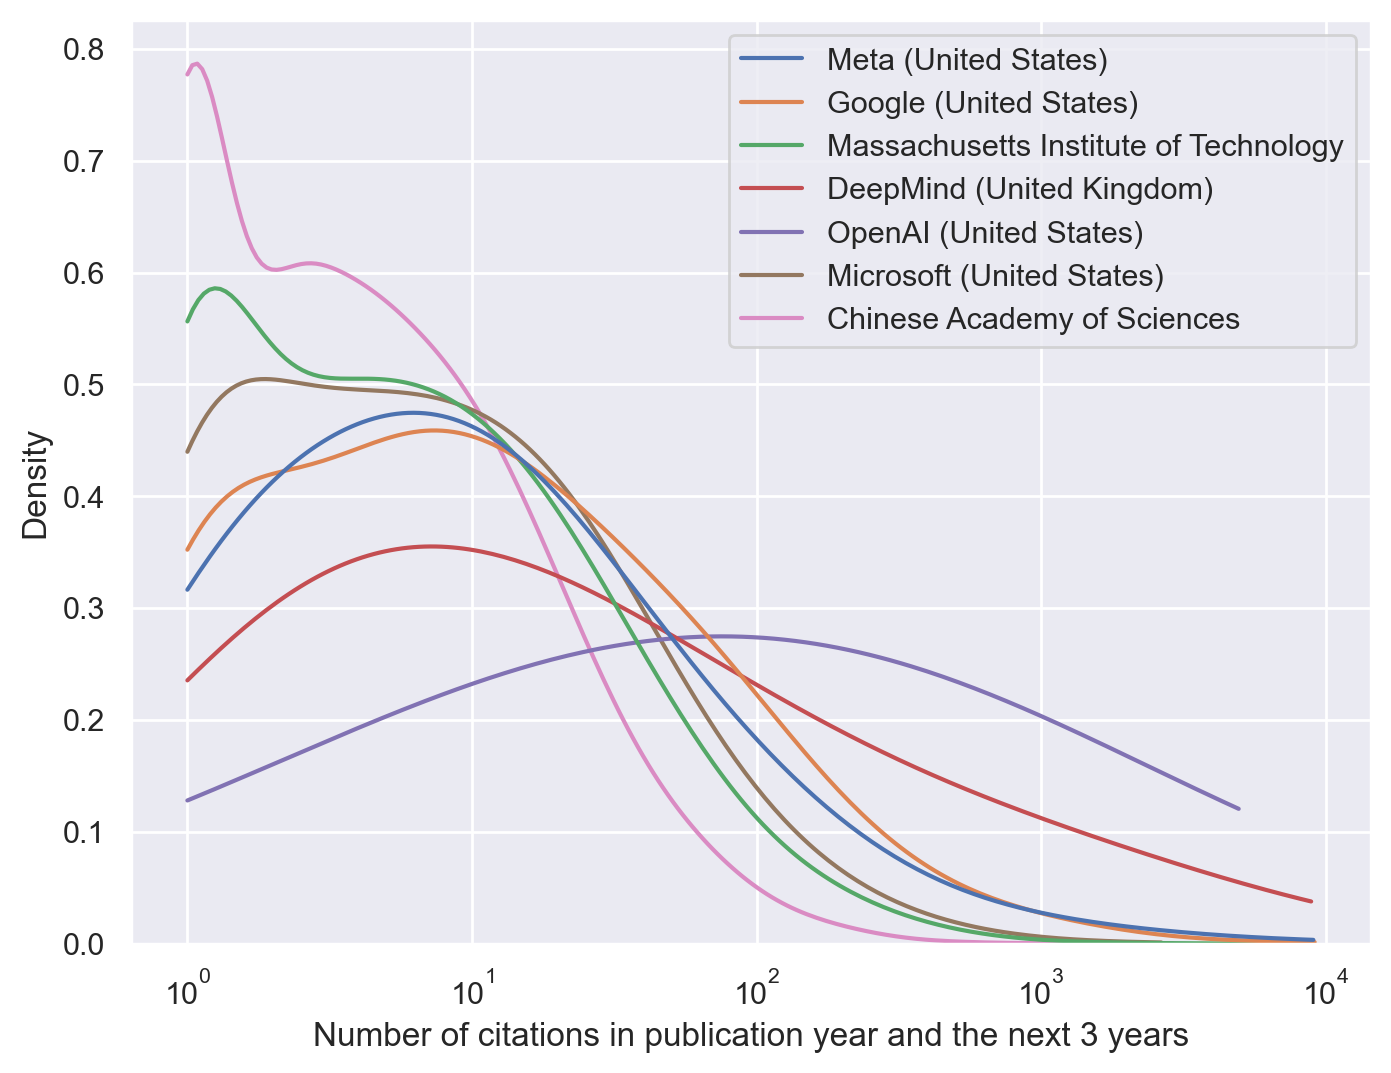

In [110]:
# for ins, cited_by_distribution in institution_cited_by_distribution.items():
plt.figure(figsize=(8, 6), dpi=200)
sns.kdeplot(
    data={
        Institutions()[ins]['display_name']: cited_by_distribution + 1
        for ins, cited_by_distribution in institution_cited_by_distribution.items()
    },
    log_scale=True,
    common_norm=False,
    bw_adjust=3,
    cut=0,
)
plt.xlabel('Number of citations in publication year and the next 3 years')

### Field authors

In [55]:
fig = go.Figure()
fig.add_trace(
    go.Scatter(
        x=total_author_counts['year'],
        y=np.log10(total_author_counts),
        name=get_entity_name(ins),
        mode='lines+markers',
    ),
)

## Plot layout
dates = np.arange(2010, 2022 + 1)
y_ticks = np.arange(0, 101, 10)
y_tick_text = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

# set_default_fig_layout(fig, dates, dates, y_ticks, y_tick_text)

fig.update_layout(
    title='Number of unique authors on AI papers',
    xaxis_title='Year',
    yaxis_title='Number of unique authors',
)

fig.update_layout(
    legend=dict(
        title=">=1 author affiliated with:"
    )
)

fig.update_layout(
    autosize=False,
    width=800,
    height=600,
    title_x=0.5,
    margin=dict(l=100, r=30, t=80, b=80),
)

## Save plot
# fig.write_image(result_file_location + 'num_authors_google_oai_dm.png', scale=2)

## Show plot
fig.show()

### Field authors

In [56]:
fig = go.Figure()
fig.add_trace(
    go.Scatter(
        x=ai_concept_cited_by_count.loc[ai_concept_cited_by_count != 0]['year'],
        y=np.log10(np.cumsum(ai_concept_cited_by_count.loc[ai_concept_cited_by_count != 0])),
        mode='lines+markers',
    ),
)

## Plot layout

fig.update_layout(
    title='Cumulative citations for AI works',
    xaxis_title='Year',
    yaxis_title='Cumulative citations (log10)',
)

fig.update_layout(
    autosize=False,
    width=800,
    height=600,
    title_x=0.5,
    margin=dict(l=100, r=30, t=80, b=80),
)

## Save plot
fig.write_image(result_file_location + 'ai_citations.png', scale=2)

## Show plot
fig.show()

### Authors

In [57]:
fig = go.Figure()
for ins, author_counts in institution_author_count.items():
    fig.add_trace(
        go.Scatter(
            x=author_counts['year'],
            y=np.log10(author_counts),
            name=get_entity_name(ins),
            mode='lines+markers',
        ),
    )

## Plot layout
dates = np.arange(2010, 2022 + 1)
y_ticks = np.arange(0, 101, 10)
y_tick_text = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

# set_default_fig_layout(fig, dates, dates, y_ticks, y_tick_text)

fig.update_layout(
    title='Number of unique authors on AI/ML works',
    xaxis_title='Year',
    yaxis_title='Number of unique authors (log10)',
)

fig.update_layout(
    legend=dict(
        title="At least one author affiliated with:"
    )
)

fig.update_layout(
    autosize=False,
    width=800,
    height=600,
    title_x=0.5,
    margin=dict(l=100, r=30, t=80, b=80),
)

## Save plot
# fig.write_image(result_file_location + 'num_authors_log10.png', scale=2)

## Show plot
fig.show()

In [58]:
total_author_counts = xr.DataArray(np.zeros(13), dims=['year'], coords={'year': np.arange(2010, 2022 + 1)})
for author_counts in institution_author_count.values():
    print(author_counts)
    for count in author_counts:
        total_author_counts.loc[count.year] += count
        # print(year, count)
        # total_author_counts += author_counts
    print(total_author_counts)
    print("====")

<xarray.DataArray (year: 13)>
array([ 6.00e+00,  2.40e+01,  2.10e+01,  1.70e+01,  4.60e+01,  4.30e+01,
        2.70e+01,  8.00e+01,  1.36e+02,  2.17e+02,  4.32e+02,  5.09e+02,
        2.17e+02])
Coordinates:
  * year     (year) int64 2010 2011 2012 2013 2014 ... 2018 2019 2020 2021 2022
<xarray.DataArray (year: 13)>
array([ 6.00e+00,  2.40e+01,  2.10e+01,  1.70e+01,  4.60e+01,  4.30e+01,
        2.70e+01,  8.00e+01,  1.36e+02,  2.17e+02,  4.32e+02,  5.09e+02,
        2.17e+02])
Coordinates:
  * year     (year) int64 2010 2011 2012 2013 2014 ... 2018 2019 2020 2021 2022
====
<xarray.DataArray (year: 13)>
array([ 2.27e+02,  2.96e+02,  3.59e+02,  3.79e+02,  4.28e+02,  5.80e+02,
        8.31e+02,  1.06e+03,  1.53e+03,  2.19e+03,  2.43e+03,  2.48e+03,
        1.58e+03])
Coordinates:
  * year     (year) int64 2010 2011 2012 2013 2014 ... 2018 2019 2020 2021 2022
<xarray.DataArray (year: 13)>
array([ 2.33e+02,  3.20e+02,  3.80e+02,  3.96e+02,  4.74e+02,  6.23e+02,
        8.58e+02,  1.14e+03,

In [59]:
fig = go.Figure()
for ins, cited_by_counts in institution_works_per_author.items():
    sorted_counts = sorted(cited_by_counts.items())
    years = list(zip(*sorted_counts))[0]
    counts = list(zip(*sorted_counts))[1]
    fig.add_trace(
        go.Scatter(
            x=years,
            y=counts,
            name=get_entity_name(ins),
            mode='lines+markers',
        ),
    )

## Plot layout
dates = np.arange(2010, 2022 + 1)
y_ticks = np.arange(0, 101, 10)
y_tick_text = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

# set_default_fig_layout(fig, dates, dates, y_ticks, y_tick_text)

fig.update_layout(
    title='Number of AI/ML works per author',
    xaxis_title='Publication year',
    yaxis_title='Average works per affiliated author',
)

fig.update_layout(
    legend=dict(
        title=">=1 author affiliated with:"
    )
)

fig.update_layout(
    autosize=False,
    width=800,
    height=600,
    title_x=0.5,
    margin=dict(l=100, r=30, t=80, b=80),
)

## Save plot
# fig.write_image(result_file_location + 'works_per_author.png', scale=2)

## Show plot
fig.show()

NameError: name 'institution_works_per_author' is not defined

### Citations

In [63]:
fig = go.Figure()
for ins, cited_by_counts in institution_cited_by_counts.items():
    fig.add_trace(
        go.Scatter(
            x=cited_by_counts['year'],
            y=np.log10(cited_by_counts),
            name=get_entity_name(ins),
            mode='lines+markers',
        ),
    )

## Plot layout
dates = np.arange(2010, 2022 + 1)
y_ticks = np.arange(0, 101, 10)
y_tick_text = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

# set_default_fig_layout(fig, dates, dates, y_ticks, y_tick_text)

fig.update_layout(
    title='Number of citations on AI/ML works',
    xaxis_title='Publication year',
    yaxis_title='Total citations in next 3 years (log10)',
)

fig.update_layout(
    legend=dict(
        title=">=1 author affiliated with:"
    )
)

fig.update_layout(
    autosize=False,
    width=800,
    height=600,
    title_x=0.5,
    margin=dict(l=100, r=30, t=80, b=80),
)

## Save plot
# fig.write_image(result_file_location + 'citations_log10.png', scale=2)

## Show plot
fig.show()

/Users/bencottier/miniconda3/envs/epoch/lib/python3.11/site-packages/xarray/core/computation.py:761: RuntimeWarning:

divide by zero encountered in log10



### Citations per work

In [233]:
fig = go.Figure()
for ins, cited_by_counts in institution_avg_cited_by_counts.items():
    sorted_counts = sorted(cited_by_counts.items())
    years = list(zip(*sorted_counts))[0]
    counts = list(zip(*sorted_counts))[1]
    fig.add_trace(
        go.Scatter(
            x=years,
            y=np.log10(counts),
            name=get_entity_name(ins),
            mode='lines+markers',
        ),
    )

## Plot layout
dates = np.arange(2010, 2022 + 1)
y_ticks = np.arange(0, 101, 10)
y_tick_text = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

# set_default_fig_layout(fig, dates, dates, y_ticks, y_tick_text)

fig.update_layout(
    title='Average number of citations on AI/ML works',
    xaxis_title='Publication year',
    yaxis_title='Average citations in next 3 years (log10)',
)

fig.update_layout(
    legend=dict(
        title=">=1 author affiliated with:"
    )
)

fig.update_layout(
    autosize=False,
    width=800,
    height=600,
    title_x=0.5,
    margin=dict(l=100, r=30, t=80, b=80),
)

## Save plot
fig.write_image(result_file_location + 'avg_citations_log10.png', scale=2)

## Show plot
fig.show()

### Citations per author

In [64]:
fig = go.Figure()
for ins, cited_by_counts in institution_cited_by_count_per_author.items():
    sorted_counts = sorted(cited_by_counts.items())
    years = list(zip(*sorted_counts))[0]
    counts = list(zip(*sorted_counts))[1]
    fig.add_trace(
        go.Scatter(
            x=years,
            y=np.log10(counts),
            name=get_entity_name(ins),
            mode='lines+markers',
        ),
    )

## Plot layout
dates = np.arange(2010, 2022 + 1)
y_ticks = np.arange(0, 101, 10)
y_tick_text = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

# set_default_fig_layout(fig, dates, dates, y_ticks, y_tick_text)

fig.update_layout(
    title='Citations per author on AI/ML works',
    xaxis_title='Publication year',
    yaxis_title='Citations in next 3 years, per affiliated author (log10)',
)

fig.update_layout(
    legend=dict(
        title=">=1 author affiliated with:"
    )
)

fig.update_layout(
    autosize=False,
    width=800,
    height=600,
    title_x=0.5,
    margin=dict(l=100, r=30, t=80, b=80),
)

## Save plot
fig.write_image(result_file_location + 'citations_per_author_log10.png', scale=2)

## Show plot
fig.show()

NameError: name 'institution_cited_by_count_per_author' is not defined

### Citations per work per author

Note: this is the average number of citations per work, divided by the TOTAL number of authors affiliated with the given organization on all works in the given year.

It is NOT dividing by the number of authors on _each_ work.

In [235]:
fig = go.Figure()
for ins, cited_by_counts in institution_avg_cited_by_count_per_author.items():
    sorted_counts = sorted(cited_by_counts.items())
    years = list(zip(*sorted_counts))[0]
    counts = list(zip(*sorted_counts))[1]
    fig.add_trace(
        go.Scatter(
            x=years,
            y=np.log10(counts),
            name=get_entity_name(ins),
            mode='lines+markers',
        ),
    )

## Plot layout
dates = np.arange(2010, 2022 + 1)
y_ticks = np.arange(0, 101, 10)
y_tick_text = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

# set_default_fig_layout(fig, dates, dates, y_ticks, y_tick_text)

fig.update_layout(
    title='Average citations per author on AI/ML works',
    xaxis_title='Publication year',
    yaxis_title='Average citations in next 3 years, per affiliated author (log10)',
)

fig.update_layout(
    legend=dict(
        title="At least one author affiliated with:"
    )
)

fig.update_layout(
    autosize=False,
    width=800,
    height=600,
    title_x=0.5,
    margin=dict(l=100, r=30, t=80, b=80),
)

## Save plot
fig.write_image(result_file_location + 'avg_citations_per_author_log10.png', scale=2)

## Show plot
fig.show()

# [END]